***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [5. Imaging](0_introduction.ipynb)  
    * Previous: [5.2 Sampling Functions and PSFs](2_sampling_functions_and_psfs.ipynb)  
***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib
from scipy import optimize
#from lofar import bdsm
import pyfits

matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'figure.figsize': [12,8]} )

# Introduction
In radio astronomy, *source finding* is the process through which the attributes of radio sources -- such as flux density and mophorlogy -- are measured from data. This lecture will only cover source finding in the image plane.


Source finding techniques usually involve four steps, i) charecterizing the noise (or background estimation), ii) thresholding the data based on knowledge of the noise, iii) fidinding regions in the thresholded image which neighbouring pixels are "similar" (this process is often called *blob detection*), and iv) parameterizing these blobs through a carefully chosen function (usually a 2D Gaussian). The source attribues are then estimated from the parameterization of the blobs.

## Noise charecterization
As mentioned before, the radio data we process with source finders is noisy. In fact, radio images are generally dominated by noise. To charecterise this noise we need to make a few assumptions about its nature, namely we assume that the niose results from some stochastic process and that it can be described by a normal distribution

$$ G(x| \mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}}\text{exp}\left( \frac{-(x-\mu)^2}{2\sigma^2}\right) $$  

where, $\mu$ is the mean (or expected value) of the varaible $x$, and $\sigma^2$ is the varience of the distribution; $\sigma$ is the standard deviation. Hence, the noise can be parameterized through the mean and the standard deviation. Let us illustrate this with an example. Bellow is a noise image from a MeerKAT simulation, along with a histogram of of the pixels (in log space).

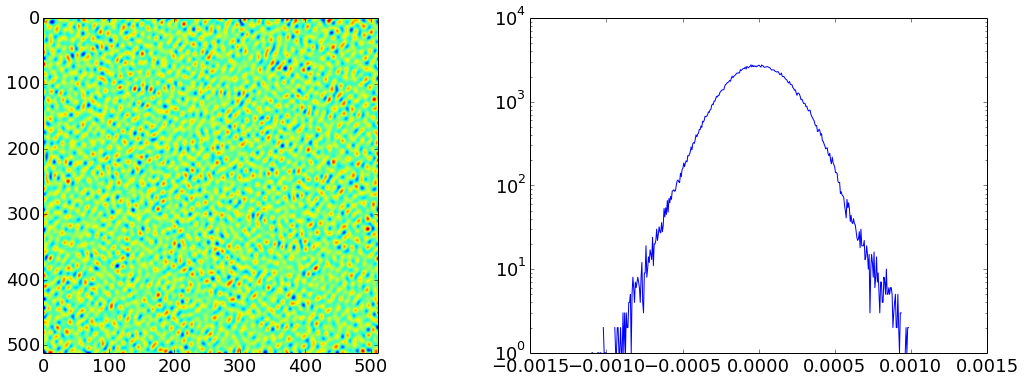

In [8]:
noise_image = "figures/noise_image.fits"
with pyfits.open(noise_image) as hdu:
    data = hdu[0].data[0,0,...]

fig, (image, hist) = plt.subplots(1, 2, figsize=(18,6))
histogram, bins = np.histogram(data.flatten(), bins=401)

dmin = data.min()
dmax = data.max()
x = np.linspace(dmin, dmax, 401)

im = image.imshow(data)
hist.plot(x, histogram)
hist.set_yscale('log')


(1, 10000.0)

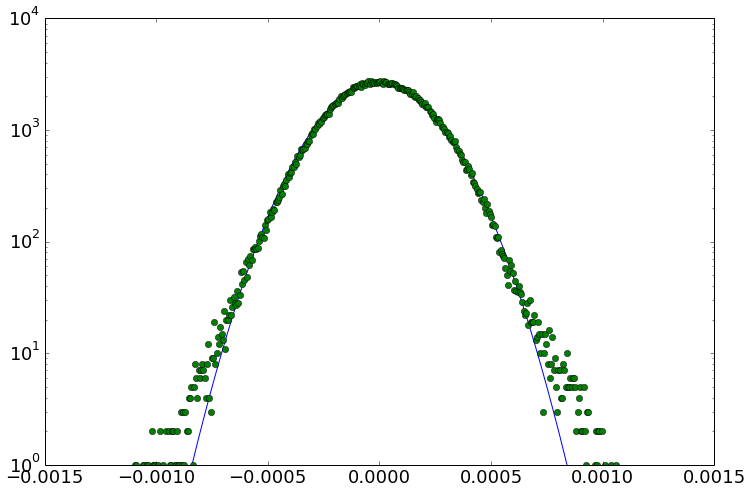

In [9]:
mean = data.mean()
sigma = data.std()
peak = histogram.max()

gauss = lambda x, amp, mean, sigma: amp*np.exp( -(x-mean)**2/(2*sigma**2))

fitdata = gauss(x, peak, mean, sigma)

plt.plot(x, fitdata)
plt.plot(x, histogram, "o")
plt.yscale('log')
plt.ylim(1)

Now, in reality the noise has to measured in the presence of astrophysical emission. Futhermore, radio iamges are also contaminated by various instrumental effects which manifest as spurious emission in radio images. blah blah ... All these factors make it difficult to charercterize the noise in a radio image. However, since the noise generally dominates the images, the mean and standard deviation of the entire image are still fairly good approximations of the noise. Let us now insert a few sources in the noise image from earlier and then try to estimate noise.

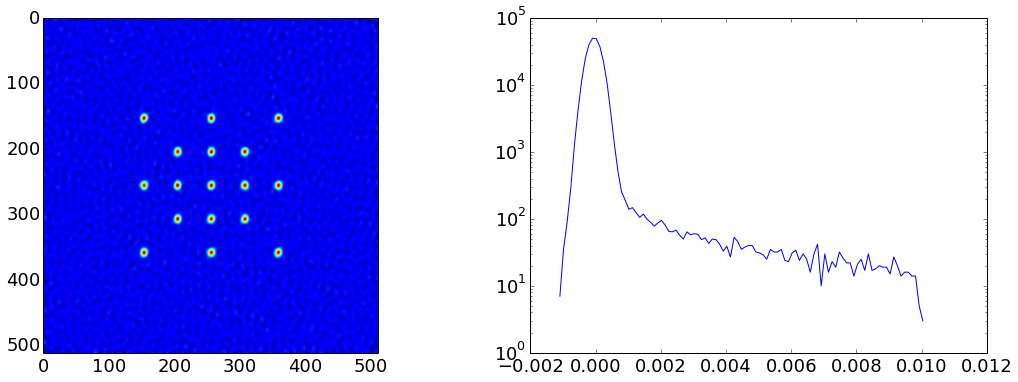

In [10]:
noise_image = "figures/star_model_image.fits"
with pyfits.open(noise_image) as hdu:
    data = hdu[0].data[0,0,...]

fig, (image, hist) = plt.subplots(1, 2, figsize=(18,6))
histogram, bins = np.histogram(data.flatten(), bins=101)


dmin = data.min()
dmax = data.max()
x = np.linspace(dmin, dmax, 101)

im = image.imshow(data)
hist.plot(x, histogram)
hist.set_yscale('log')


(1, 100000.0)

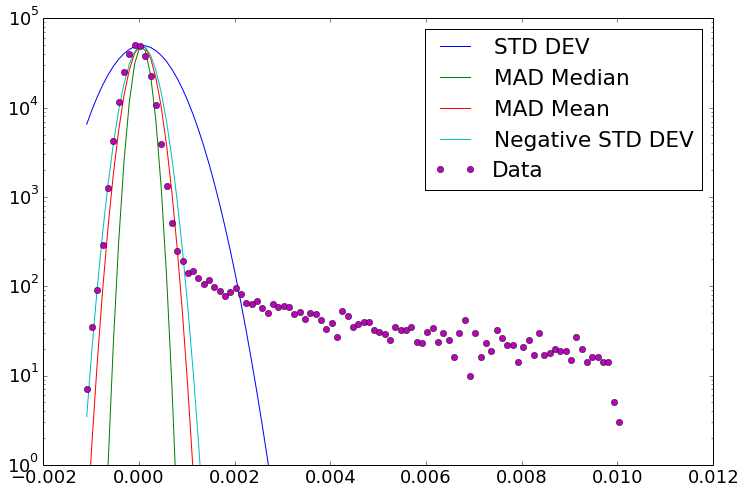

In [11]:
mean = data.mean()
sigma_std = data.std()
sigma_neg = data[data<0].std()*2
sigma_mad_median = np.median( abs(data - np.median(data) ))
sigma_mad_mean = np.mean( abs(data - np.mean(data) ))

peak = histogram.max()

gauss = lambda x, amp, mean, sigma: amp*np.exp( -(x-mean)**2/(2*sigma**2))

fitdata_std = gauss(x, peak, mean, sigma_std)
fitdata_mad_median = gauss(x, peak, mean, sigma_mad_median)
fitdata_mad_mean = gauss(x, peak, mean, sigma_mad_mean)
fitdata_neg = gauss(x, peak, mean, sigma_neg)

plt.plot(x, fitdata_std, label="STD DEV")
plt.plot(x, fitdata_mad_median, label="MAD Median")
plt.plot(x, fitdata_mad_mean, label="MAD Mean")
plt.plot(x, fitdata_neg, label="Negative STD DEV")
plt.plot(x, histogram, "o", label="Data")
plt.legend(loc=1)

plt.yscale('log')
plt.ylim(1)

## Blob Detection and Charercterization

Once the noise has been estimated, the next step is to find and charecterize blobs in the image. First, we need a more formal definition of a blob. We define a blob as a group contiguous pixels whose spatial intensity profile can be modelled by a 2D Gaussian function. And, since we are dealing with images from physical instruments which have a finite resolution (at least in the image plane), we further constrain our blobs not to be significantly smaller than the image resolution. Finally, we need to define two last constraints of a blob, the *peak* and *boundary* thresholds. The peak threshold, defined as

$$ 
    \sigma_\text{peak} = n * \sigma,
$$

is the minimum intensity the maximum pixel in a blob must have. That is, all blobs with peak pixel lower than $\sigma_\text{peak}$ will be excluded. And the bouandary threshold,

$$
    \sigma_\text{boundary} = m * \sigma
$$

Defines the bounadry of a blob. $\sigma$ is an estimation of the image noise, and $m$ and $n$ are natural numbers with $m$ < $n$. 

<matplotlib.colorbar.Colorbar instance at 0x7f140cb39d88>

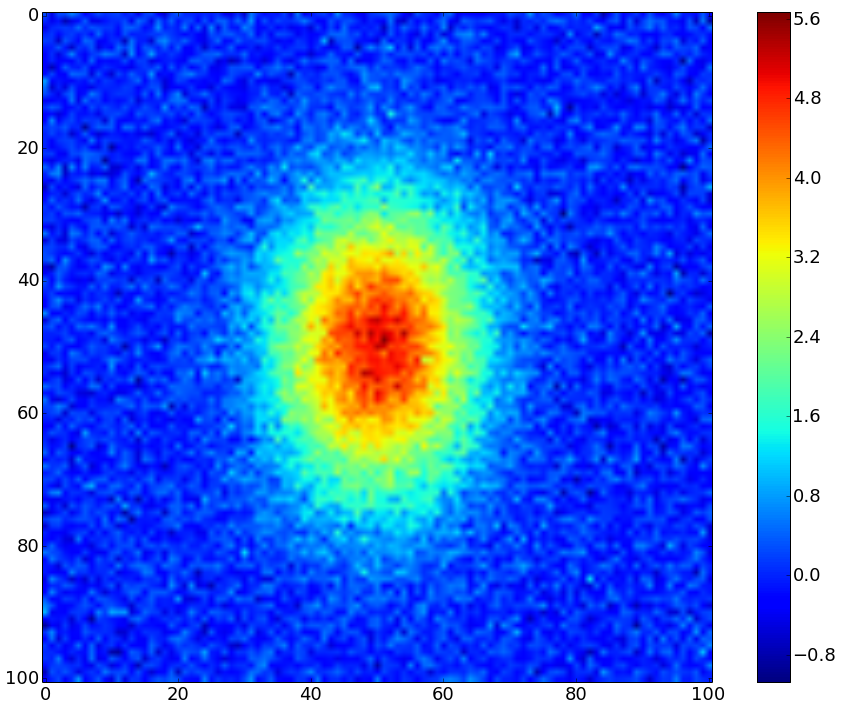

In [15]:
def gauss2D(x, y, amp, meanx, meany, sigmax, sigmay):
    gx = -(x - meanx)**2/(2*sigmax**2)
    gy = -(y - meany)**2/(2*sigmay**2)
    
    return amp * np.exp( gx + gy)

# Generate clean data
x = np.linspace(0, 100, 101)
xx, yy = np.meshgrid(x, x)

data_clean = gauss2D(xx, yy, 5, 50, 50, 10.5, 15.4)

# Add noise
data = data_clean + np.random.randn(*data_clean.shape)*0.3

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
im = ax.imshow(data)
plt.colorbar(im)

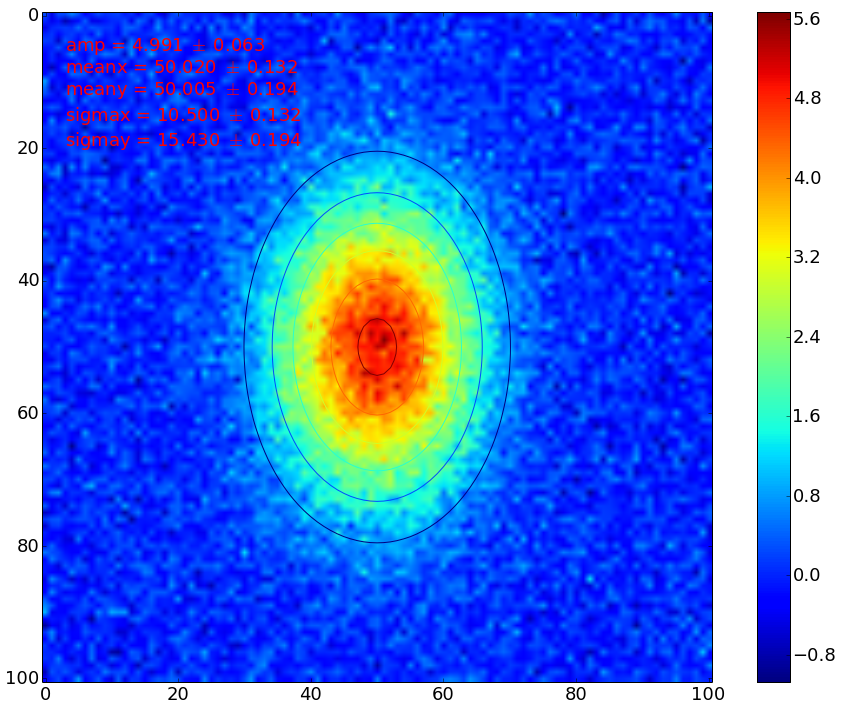

In [19]:
def err(p, xx, yy, data):
    return gauss2D(xx.flatten(), yy.flatten(), *p) - data.flatten()

# Initial estimate
params0 = 4.00, 44, 55, 7.5, 20.0

params, pcov, infoDict, errmsg, sucess = optimize.leastsq(err, 
                        params0, args=(xx.flatten(), yy.flatten(), data.flatten()), full_output=1)

fig, ax = plt.subplots(1, 1, figsize=(16,12))
im = ax.imshow(data)
ax.contour(gauss2D(xx,yy, *params))
plt.colorbar(im)

perr = abs(np.diagonal(pcov))**0.5

text = """
amp = %.3f $\pm$ %.3f
meanx = %.3f $\pm$ %.3f
meany = %.3f $\pm$ %.3f
sigmax = %.3f $\pm$ %.3f
sigmay = %.3f $\pm$ %.3f
"""%(params[0], perr[0], params[1], perr[1], params[2], perr[2],
     params[3], perr[3], params[4], perr[4])

ax.text(3, 23, text,color="r")

## Source Finding Packages